In [1]:
# imports
import torch
from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,
)
from pytorch3d.renderer.cameras import (
    SfMPerspectiveCameras,
)

# add path for demo utils
import sys
import os
sys.path.append(os.path.abspath(''))

# set for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [2]:
from camera_visualization import plot_camera_scene

In [3]:
# load the SE3 graph of relative/absolute camera positions
camera_graph_file = './data/camera_graph.pth'
(R_absolute_gt, T_absolute_gt), \
    (R_relative, T_relative), \
    relative_edges = \
        torch.load(camera_graph_file)

In [4]:
# create the relative cameras
cameras_relative = SfMPerspectiveCameras(
    R = R_relative.to(device),
    T = T_relative.to(device),
    device = device,
)

In [5]:
# create the absolute ground truth cameras
cameras_absolute_gt = SfMPerspectiveCameras(
    R = R_absolute_gt.to(device),
    T = T_absolute_gt.to(device),
    device = device,
)

# the number of absolute camera positions
N = R_absolute_gt.shape[0]

In [6]:
def calc_camera_distance(cam_1, cam_2):
    """
    Calculates the divergence of a batch of pairs of cameras cam_1, cam_2.
    The distance is composed of the cosine of the relative angle between 
    the rotation components of the camera extrinsics and the l2 distance
    between the translation vectors.
    """
    # rotation distance
    R_distance = (1.-so3_relative_angle(cam_1.R, cam_2.R, cos_angle=True)).mean()
    # translation distance
    T_distance = ((cam_1.T - cam_2.T)**2).sum(1).mean()
    # the final distance is the sum
    return R_distance + T_distance

def get_relative_camera(cams, edges):
    """
    For each pair of indices (i,j) in "edges" generate a camera
    that maps from the coordinates of the camera cams[i] to 
    the coordinates of the camera cams[j]
    """

    # first generate the world-to-view Transform3d objects of each 
    # camera pair (i, j) according to the edges argument
    trans_i, trans_j = [
        SfMPerspectiveCameras(
            R = cams.R[edges[:, i]],
            T = cams.T[edges[:, i]],
            device = device,
        ).get_world_to_view_transform()
         for i in (0, 1)
    ]
    
    # compose the relative transformation as g_i^{-1} g_j
    trans_rel = trans_i.inverse().compose(trans_j)
    
    # generate a camera from the relative transform
    matrix_rel = trans_rel.get_matrix()
    cams_relative = SfMPerspectiveCameras(
                        R = matrix_rel[:, :3, :3],
                        T = matrix_rel[:, 3, :3],
                        device = device,
                    )
    return cams_relative

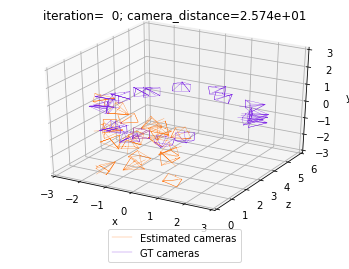

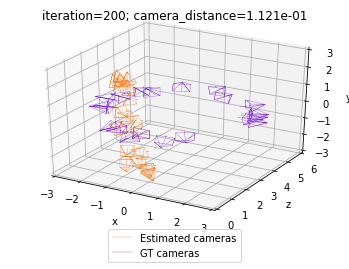

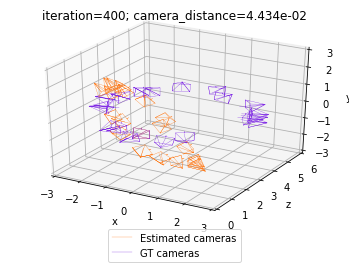

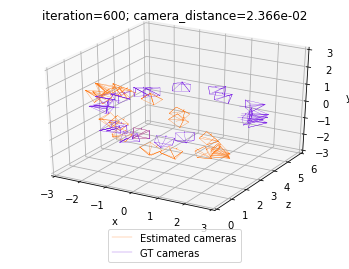

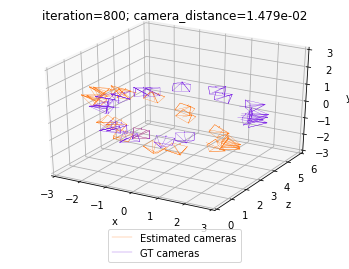

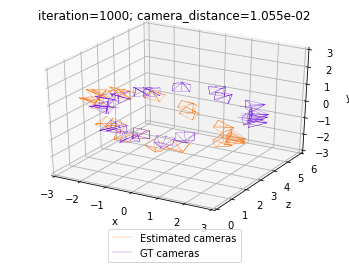

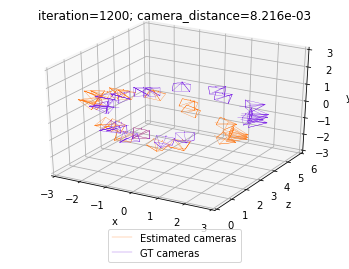

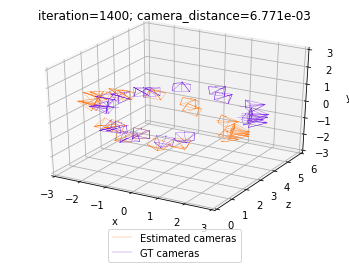

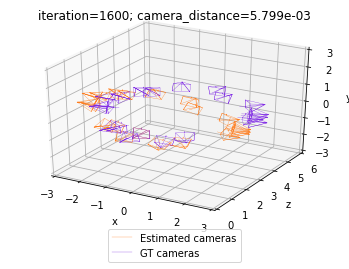

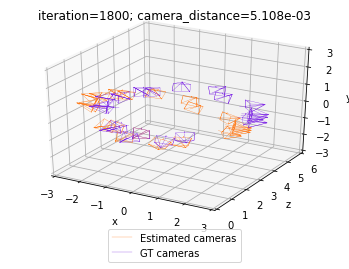

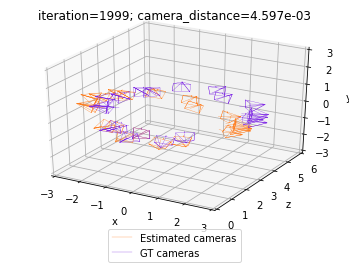

Optimization finished.


In [7]:
# initialize the absolute log-rotations/translations with random entries
log_R_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)
T_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)

# furthermore, we know that the first camera is a trivial one 
#    (see the description above)
log_R_absolute_init[0, :] = 0.
T_absolute_init[0, :] = 0.

# instantiate a copy of the initialization of log_R / T
log_R_absolute = log_R_absolute_init.clone().detach()
log_R_absolute.requires_grad = True
T_absolute = T_absolute_init.clone().detach()
T_absolute.requires_grad = True

# the mask the specifies which cameras are going to be optimized
#     (since we know the first camera is already correct, 
#      we only optimize over the 2nd-to-last cameras)
camera_mask = torch.ones(N, 1, dtype=torch.float32, device=device)
camera_mask[0] = 0.

# init the optimizer
optimizer = torch.optim.SGD([log_R_absolute, T_absolute], lr=.1, momentum=0.9)

# run the optimization
n_iter = 2000  # fix the number of iterations
for it in range(n_iter):
    # re-init the optimizer gradients
    optimizer.zero_grad()

    # compute the absolute camera rotations as 
    # an exponential map of the logarithms (=axis-angles)
    # of the absolute rotations
    R_absolute = so3_exponential_map(log_R_absolute * camera_mask)

    # get the current absolute cameras
    cameras_absolute = SfMPerspectiveCameras(
        R = R_absolute,
        T = T_absolute * camera_mask,
        device = device,
    )

    # compute the relative cameras as a compositon of the absolute cameras
    cameras_relative_composed = \
        get_relative_camera(cameras_absolute, relative_edges)

    # compare the composed cameras with the ground truth relative cameras
    # camera_distance corresponds to $d$ from the description
    camera_distance = \
        calc_camera_distance(cameras_relative_composed, cameras_relative)

    # our loss function is the camera_distance
    camera_distance.backward()
    
    # apply the gradients
    optimizer.step()

    # plot and print status message
    if it % 200==0 or it==n_iter-1:
        status = 'iteration=%3d; camera_distance=%1.3e' % (it, camera_distance)
        plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)

print('Optimization finished.')